# Experiment plotting

This notebook contains the code for plotting results for the different experiments.
When run for the first time for a town, condensed summary files are being created which strongly speed up subsequent generations of plots from the same summaries. It is possible to create the plots only from the condensed summaries located in 'summaries/condensed_summaries'.
Note that this works for all experiments but the Rt plots, which still require the full summary file.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import pandas as pd
import pickle
import itertools
from lib.measures import *
from lib.experiment import Experiment, Plot, Result, get_properties, load_summary_list, load_summary
from lib.data import collect_data_from_df
from lib.calibrationSettings import calibration_lockdown_dates, calibration_start_dates, calibration_mob_paths
from lib.calibrationFunctions import get_calibrated_params, downsample_cases
import lib.plot as lib_plot
from lib.plot import Plotter
import matplotlib.pyplot as plt
from lib.summary import load_condensed_summary

In [4]:
commithash = '594b678'# 'cd1d945'
baseline_commithash = '594b678'#cd1d945'
# baseline_commithash = '75f335d'
tracing_commithash = '594b678' #'364e318'

# Model validation

\subsection{Model validation}
(2x3 or 2x4 double-column panel) with 2 rows of: beta heatmap and model fit plots next to it



## Transferability of parameters

FileNotFoundError: [Errno 2] No such file or directory: 'condensed_summaries/validation-BE-0ba76d9/validation-BE-validation_region=BE_condensed.pk'

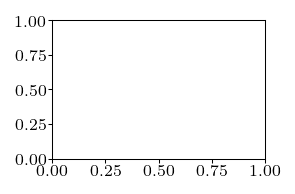

In [5]:
def plot_model_fit_and_transferability(calibration_region='BE', ymax=None, show_legend=True):

    regions = {
               'BE': [('CH', 'BE'), ('GER', 'KL'), ('GER', 'TU')], 
               'JU': [('CH', 'JU'), ('GER', 'SB'), ('GER', 'RH')]
              }
    
    ymax = {'GER': {'TU': 1200, 'SB': 500, 'KL': 500, 'RH': 749, 'TR': 2000,},
                 'CH': {'VD': 2000, 'BE': 590, 'TI': 500, 'JU': 500,}}

    for country, area in regions[calibration_region]:
        labels = ['Simulated cases']
        paths = [f'validation-{calibration_region}-{commithash}/validation-{calibration_region}-validation_region={area}.pk']
        plot_filename = f'Modelfit-{calibration_region}-{area}'
        
        plotter = Plotter()
        
        ts, predicted = plotter.plot_positives_vs_target(
            paths=paths, 
            labels=labels,
            country=country,
            area=area,
            ymax=ymax[country][area],
            lockdown_label_y=ymax[country][area]/8,
            filename=plot_filename,
            figsize=lib_plot.FIG_SIZE_NEURIPS_TRIPLE,
            figformat='neurips-double',
            small_figure=True,
            show_legend=show_legend)

plot_model_fit_and_transferability(calibration_region='BE')

## Calibration parameter heatmaps

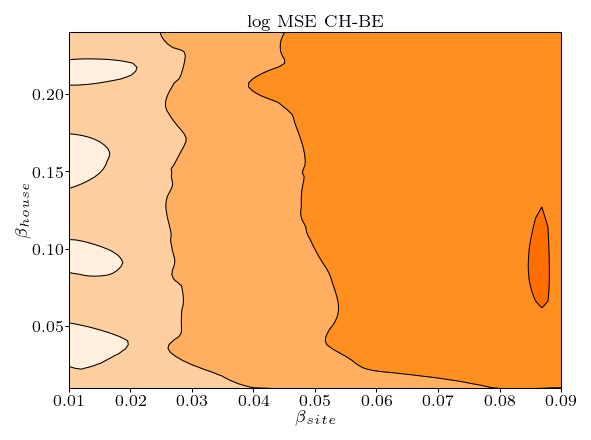

In [5]:
plotter = Plotter()
plotter.beta_parameter_heatmap(
    country='CH', 
    area='BE', 
    calibration_state='logs/calibration_be0_state.pk',
    figsize=(4, 3),
    cmap='gist_heat_r',
#    cmap='viridis_r',    
    levels=15,
)

# Social distancing

Social distancing: (panel with 1 plot total infections, 1 plot peak hospitalizations) [lockdown, k=2-groups, vulnerable group, conditional measures thres=50]

Loaded previously extracted data.


FileNotFoundError: [Errno 2] No such file or directory: 'condensed_summaries/lockdown-CH-BE-594b678/lockdown-CH-BE-p_compliance=1.0-beta_multiplier=0.5_condensed.pk'

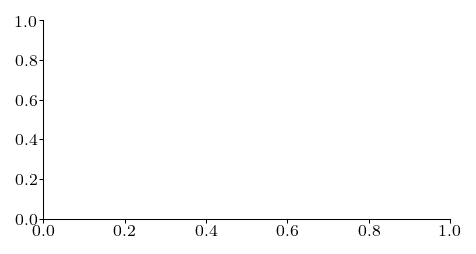

In [6]:
def plot_social_distancing_relative_reduction(*, country, area, mode, ps_adoption, plot_rt=True, plot_pmf=False, commithash=None):
        
    plot_filename = f'social-distancing-strategies-{country}-{area}'


    baseline_path= (f'baseline-{country}-{area}-9a92bc7/'
                 f'baseline-{country}-{area}'
                 f'-expected_daily_base_expo_per100k=5.0'
                 f'-beta_multiplier=0.5.pk')
    
    paths = {'Lockdown': [f'lockdown-{country}-{area}-{commithash}/'
                      f'lockdown-{country}-{area}'
                      f'-p_compliance={p_adoption}'
                      f'-beta_multiplier=0.5'
                      '.pk' for p_adoption in ps_adoption],

             'Alternating curfews': [f'k-groups-{country}-{area}-{commithash}/'
                                     f'k-groups-{country}-{area}'
                                     f'-K_groups=2'
                                     f'-p_compliance={p_adoption}'
                                     f'-beta_multiplier=0.5'
                                     f'.pk' for p_adoption in ps_adoption],
             
             'Vulnerable groups': [f'vulnerable-groups-{country}-{area}-{commithash}/'
                                     f'vulnerable-groups-{country}-{area}'
                                     f'-p_compliance={p_adoption}'
                                     f'-beta_multiplier=0.5'
                                     f'.pk' for p_adoption in ps_adoption],
             
             'Conditional measures': [f'conditional-measures-{country}-{area}-{commithash}/'
                                     f'conditional-measures-{country}-{area}'
                                     f'-max_incidence=50'
                                     f'-p_compliance={p_adoption}'
                                     f'-beta_multiplier=0.5'
                                     f'.pk' for p_adoption in ps_adoption],
            }
                 

    titles = list(paths.keys())

    plotter = Plotter()
    plotter.compare_peak_reduction(path_list=list(paths.values()), 
                                   baseline_path=baseline_path, 
                                   ps_adoption=ps_adoption,
                                   titles=titles,
                                   mode=mode,   # Allowed values ['cumu_infected', 'hosp', 'dead']
                                   filename=plot_filename,
                                   figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
                                   figformat='neurips-double')

              
plot_social_distancing_relative_reduction(
    country='CH', 
    area='BE', 
    mode='cumu_infected',   # Allowed values ['cumu_infected', 'hosp', 'dead']
    ps_adoption=[1.0, 0.75, 0.5, 0.25, 0.1],
    plot_rt=True, 
    plot_pmf=False,
    commithash=commithash
)

# Contact tracing

Contact tracing : (panel with 1 plot total infections, 1 plot peak hospitalizations) [contact tracing, delay=1, 24, 48h]

Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.


FileNotFoundError: [Errno 2] No such file or directory: 'condensed_summaries/tracing-CH-BE-594b678/tracing-CH-BE-p_adoption=1.0-test_lag=24.0-tracing_threshold=0.016-beta_multiplier=1.0_condensed.pk'

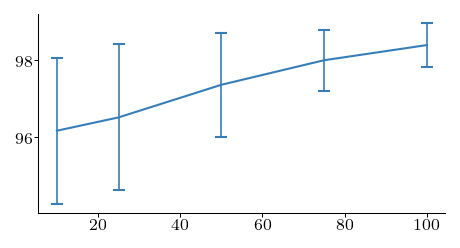

In [7]:
def plot_tracing_relative_reduction(*, country, area, mode, ps_adoption, test_lags, plot_rt=True, plot_pmf=False, commithash=None):
        
    plot_filename = f'social-distancing-strategies-{country}-{area}'
    
    baseline_path= (f'baseline-{country}-{area}-{baseline_commithash}/'
                 f'baseline-{country}-{area}'
                 f'-expected_daily_base_expo_per100k=5.0'
                 f'-beta_multiplier=1.0.pk')
    
    paths, titles = [], []
    for test_lag in test_lags:
        paths.append([f'tracing-{country}-{area}-{commithash}/'
                      f'tracing-{country}-{area}'
                      f'-p_adoption={p_adoption}'
                      f'-test_lag={test_lag}'
                      f'-tracing_threshold=0.016'
                      f'-beta_multiplier=1.0'
                      '.pk' for p_adoption in ps_adoption])
    
        titles.append(f'Tracing and testing, {test_lag}h test delay')
                 


    plotter = Plotter()
    plotter.compare_peak_reduction(path_list=paths, 
                                   baseline_path=baseline_path, 
                                   ps_adoption=ps_adoption,
                                   titles=titles,
                                   mode=mode,   # Allowed values ['cumu_infected', 'hosp', 'dead']
                                   filename=plot_filename,
                                   figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
                                   figformat='neurips-double')

              
plot_tracing_relative_reduction(
    country='CH', 
    area='BE', 
    mode='cumu_infected',   # Allowed values ['cumu_infected', 'hosp', 'dead']
    ps_adoption=[1.0, 0.75, 0.5, 0.25, 0.1],
    test_lags=[48.0, 24.0, 3.0, 1.0],
    plot_rt=True, 
    plot_pmf=False,
    commithash=tracing_commithash
)

# Overdispersion and Rt

\subsection{Overdispersion}
(2x4 double-column panel) [lockdown, k=2-groups, conditional measures 50, contact tracing 48h]

In [9]:
def plot_daily_rt_kt(country, area, experiment, p_adoption):
        
    if experiment == 'Baseline':
        path = (f'baseline-{country}-{area}-{baseline_commithash}/'
                  f'baseline-CH-BE-.pk')

    elif experiment == 'Lockdown':
        path = (f'lockdown-{country}-{area}-{commithash}/'
                      f'lockdown-{country}-{area}'
                      f'-p_compliance={p_adoption}'
                      f'-beta_multiplier=0.5'
                      '.pk')
    elif experiment == 'Alternating curfews':
        path = (f'k-groups-{country}-{area}-{commithash}/'
                             f'k-groups-{country}-{area}'
                             f'-K_groups=2'
                             f'-p_compliance={p_adoption}'
                             f'-beta_multiplier=0.5'
                             f'.pk')
    elif experiment == 'Vulnerable groups':
        path = (f'vulnerable-groups-{country}-{area}-{commithash}/'
                             f'vulnerable-groups-{country}-{area}'
                             f'-p_compliance={p_adoption}'
                             f'-beta_multiplier=0.5'
                             f'.pk')
    elif experiment == 'Conditional measures':
        path = (f'conditional-measures-{country}-{area}-{commithash}/'
                             f'conditional-measures-{country}-{area}'
                             f'-max_incidence=50'
                             f'-p_compliance={p_adoption}'
                             f'-beta_multiplier=0.5'
                             f'.pk')
    elif experiment == 'Tracing':
        path = (f'tracing-{country}-{area}-{tracing_commithash}/'
                      f'tracing-{country}-{area}'
                      f'-p_adoption={p_adoption}'
                      f'-test_lag=48.0'
                      f'-tracing_threshold=0.016'
                      f'-beta_multiplier=0.5'
                      '.pk')
        
    plot_filename = f'{experiment}-{country}-{area}'
    
    plotter = lib_plot.Plotter()
    
    plotter.plot_daily_nbinom_rts(
        path=path, 
        filename=plot_filename+'-daily-Rt',
        figsize=lib_plot.FIG_SIZE_FULL_PAGE_TRIPLE_ARXIV, 
        figformat='neurips-double',
        ymax=4.4,
        xlim=(0, 127),
        x_axis_dates=False,
        subplots_adjust={'bottom':0.2, 'top': 0.98, 'left': 0.12, 'right': 0.96},
    )        
        
    plotter = lib_plot.Plotter()
    plotter.plot_nbinom_distributions(
        path=path,
        ymax=0.85,
        figsize=lib_plot.FIG_SIZE_FULL_PAGE_TRIPLE_ARXIV,
        figformat='neurips-double',
        filename=plot_filename+'-pmf',
    )
        

experiments = ['Baseline', 'Lockdown', 'Alternating curfews', 'Vulnerable groups', 'Conditional measures', 'Tracing']
for experiment in experiments:
    plot_daily_rt_kt('CH', 'BE', experiment=experiment, p_adoption=0.5)


# Crop pdf margins
!bash crop_pdfs.sh plots/daily-nbinom-rts-*.pdf
!bash crop_pdfs.sh plots/prob-secondaryCases-*.pdf

FileNotFoundError: [Errno 2] No such file or directory: 'condensed_summaries/baseline-CH-BE-0ba76d9/baseline-CH-BE-_condensed.pk'

# Not in paper: Different quantities over time

Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.


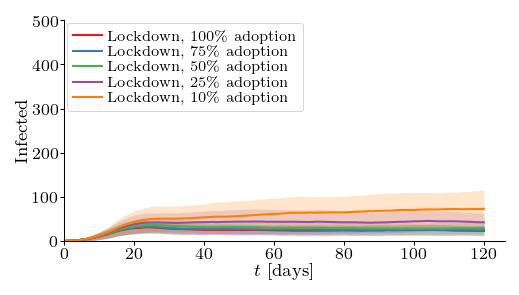

In [13]:
def plot_experiment_over_time(*, country, area, experiment, quantity, mode, ymax, ps_adoption):
    
    if experiment == 'Baseline':
        paths = [f'baseline-CH-BE-{baseline_commithash}/'
                 f'baseline-CH-BE'
                 f'-expected_daily_base_expo_per100k={bexp}'
                 f'-beta_multiplier=1.0.pk' for bexp in [5.0, 10.0, 15.0, 20.0, 25.0, 30.0]]
            
            
            
            
            
            
# #             f'baseline-{country}-{area}-{baseline_commithash}/'
# #                       f'baseline-CH-BE-'
# #                     f'beta_multiplier=0.5'
# #                     f'.pk',
#                 f'baseline-{country}-{area}-cd1d945/'
#                       f'baseline-CH-BE-.pk',
                 
#                 f'baseline-{country}-{area}-75f335d/'
#                       f'baseline-CH-BE-'
#                       f'beta_multiplier=0.5'
#                       f'.pk']
    elif experiment == 'Lockdown':
        paths = [f'lockdown-{country}-{area}-{commithash}/'
                      f'lockdown-{country}-{area}'
                      f'-p_compliance={p_adoption}'
                      f'-beta_multiplier=0.5'
                      '.pk' for p_adoption in ps_adoption]
    elif experiment == 'Alternating curfews':
        paths = [f'k-groups-{country}-{area}-{commithash}/'
                             f'k-groups-{country}-{area}'
                             f'-K_groups=2'
                             f'-p_compliance={p_adoption}'
                             f'-beta_multiplier=0.5'
                             f'.pk' for p_adoption in ps_adoption]
    elif experiment == 'Vulnerable groups':
        paths = [f'vulnerable-groups-{country}-{area}-{commithash}/'
                             f'vulnerable-groups-{country}-{area}'
                             f'-p_compliance={p_adoption}'
                             f'-beta_multiplier=0.5'
                             f'.pk' for p_adoption in ps_adoption]
    elif experiment == 'Conditional measures':
        paths = [f'conditional-measures-{country}-{area}-{commithash}/'
                             f'conditional-measures-{country}-{area}'
                             f'-max_incidence=50'
                             f'-p_compliance={p_adoption}'
                             f'-beta_multiplier=0.5'
                             f'.pk' for p_adoption in ps_adoption]
    elif experiment == 'Tracing':
        paths = [f'tracing-{country}-{area}-{tracing_commithash}/'
                      f'tracing-{country}-{area}'
                      f'-p_adoption={p_adoption}'
                      f'-test_lag=48.0'
                      f'-tracing_threshold=0.016'
                      f'-beta_multiplier=1.0'
                      '.pk' for p_adoption in ps_adoption]

    if experiment == 'Baseline':
        labels = [f'Baseline, {bexp} exposures per week per 100k people' for bexp in [5.0, 10.0, 15.0, 20.0, 25.0, 30.0]]
        # labels = [experiment, experiment + ' with beta multipliers']
    else:
        labels = [experiment+', {:3.0f}\% adoption'.format(100 * p_adoption) for p_adoption in ps_adoption]
        
    plot_filename = f'{experiment}-{country}-{area}-{mode}-{quantity}'
        
    # plots
    plotter = Plotter()

    plotter.compare_quantity(
        paths, 
        titles=labels,
        quantity=quantity,
        mode=mode,
        ymax=ymax,
        filename=plot_filename, 
        figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
        figformat='neurips-double',
        legend_is_left=True)
    
    
    
plot_experiment_over_time(
    country='CH', 
    area='BE',
    experiment='Lockdown',  # Allowed values: See function
    quantity='infected',    # Allowed values: ['infected', 'hosp', 'dead']
    mode='total',           # Allowed values: ['total', 'daily', 'cumulative', 'weekly incidence']
    ymax=500, 
    ps_adoption=[1.0, 0.75, 0.5, 0.25, 0.1],)